In [192]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import Normalizer, PowerTransformer, RobustScaler, MaxAbsScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

In [277]:
# Load Data
train_data = pd.read_csv('278_labelled_uri_train.csv')

In [278]:
# Visualize Data
# train_data.describe()
# train_data.info()
# print(train_data.keys())


labels = pd.DataFrame(train_data['labels'])
train_data.drop('labels', axis=1, inplace=True)
train_data.drop('uri', axis=1, inplace=True)

# train_data['id'] = range(len(train_data))
# labels['id'] = range(len(labels))

In [4]:
train_data.describe()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222350 entries, 0 to 222349
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0.2      222350 non-null  int64  
 1   Unnamed: 0.1      222350 non-null  int64  
 2   Unnamed: 0        222350 non-null  int64  
 3   duration (ms)     222350 non-null  float64
 4   danceability      222350 non-null  float64
 5   energy            222350 non-null  float64
 6   loudness          222350 non-null  float64
 7   speechiness       222350 non-null  float64
 8   acousticness      222350 non-null  float64
 9   instrumentalness  222350 non-null  float64
 10  liveness          222350 non-null  float64
 11  valence           222350 non-null  float64
 12  tempo             222350 non-null  float64
 13  spec_rate         222350 non-null  float64
dtypes: float64(11), int64(3)
memory usage: 23.7 MB


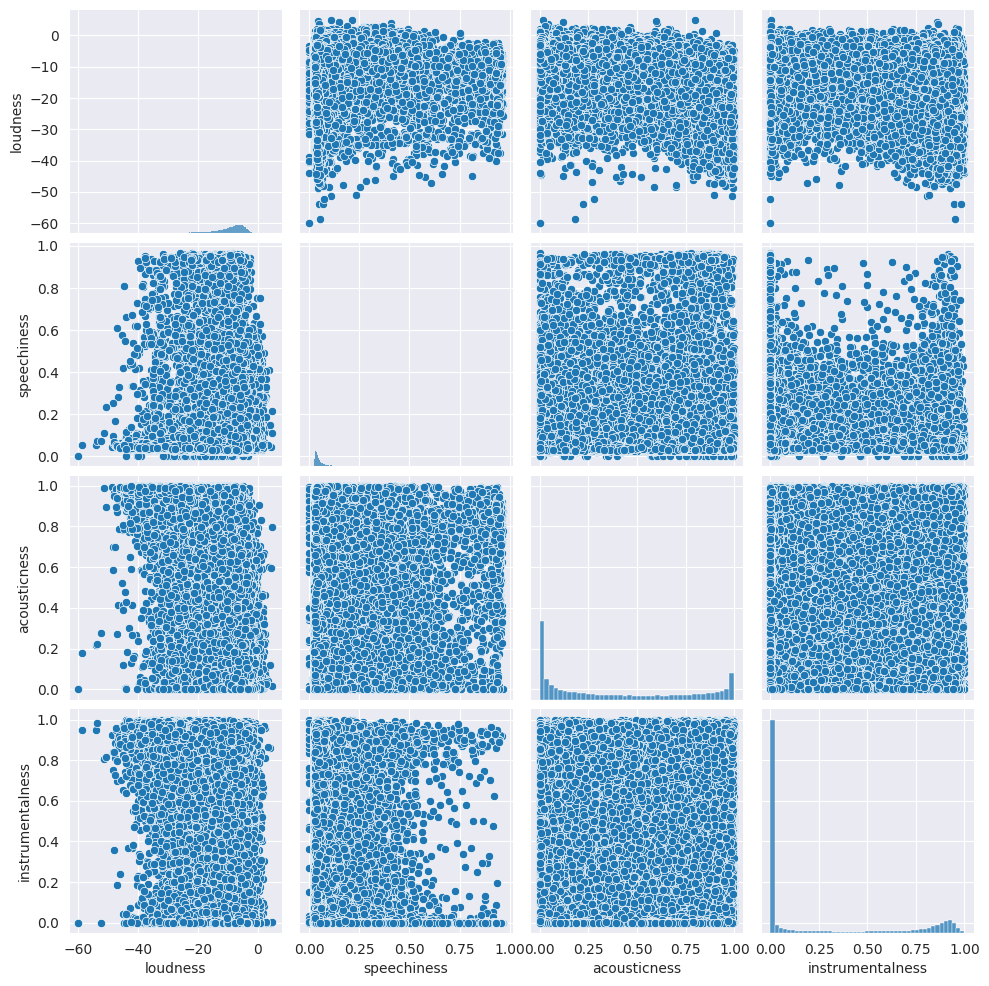

In [5]:
sns.pairplot(train_data[['loudness', 'speechiness', 'acousticness', 'instrumentalness']])

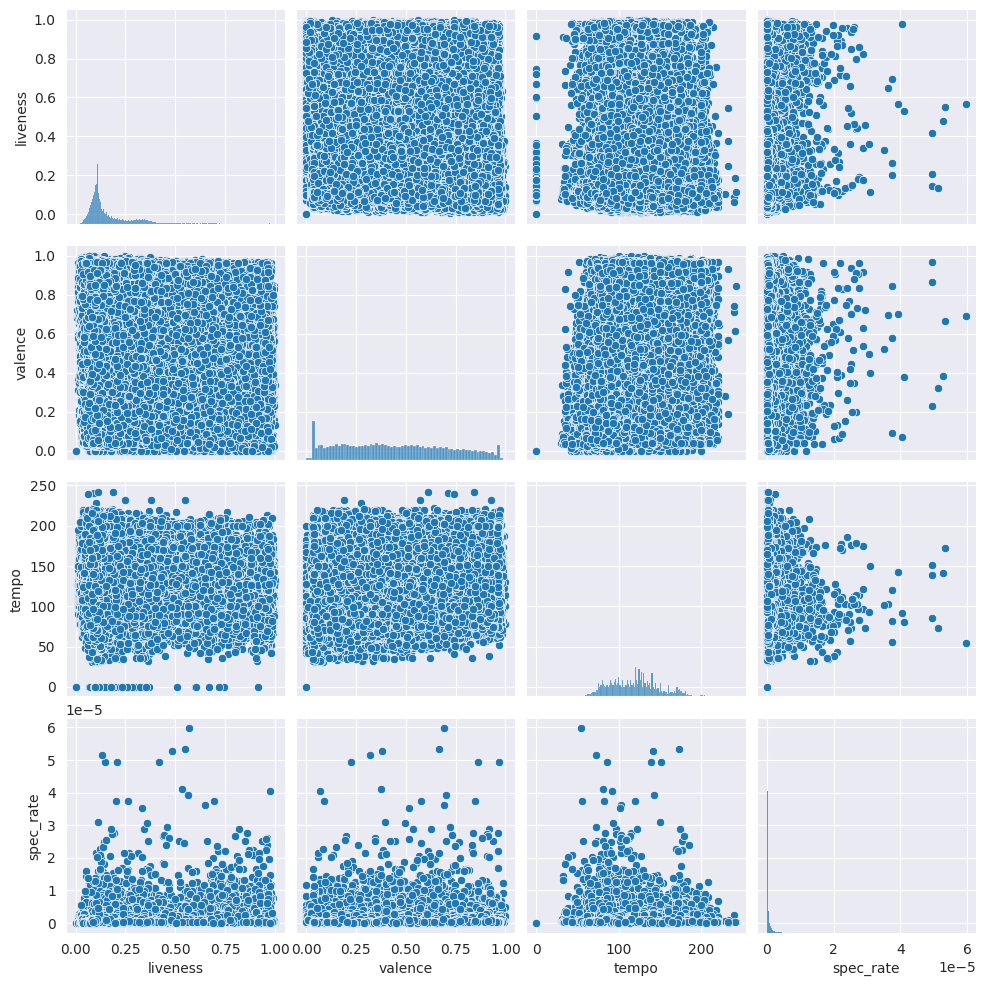

In [16]:
sns.pairplot(train_data[['liveness', 'valence', 'tempo', 'spec_rate']])

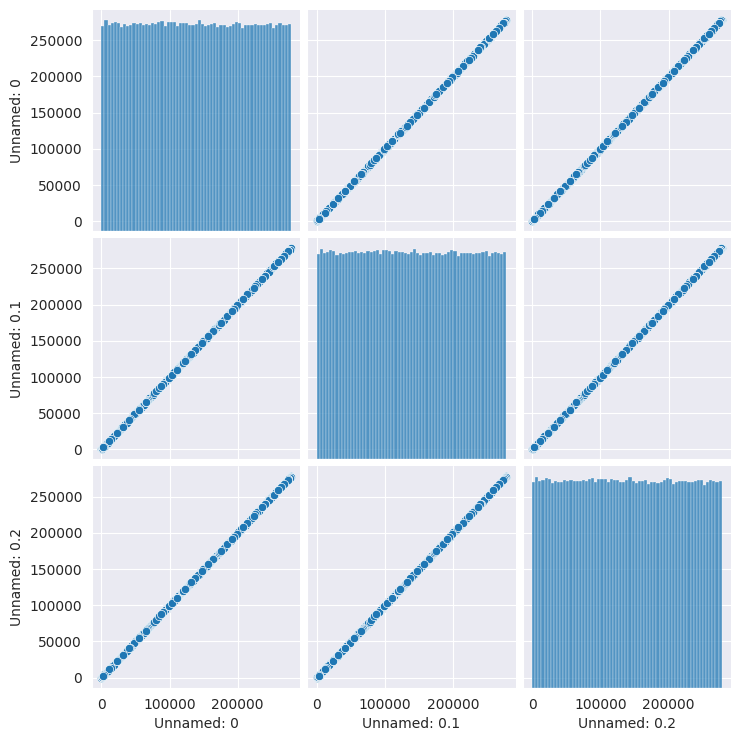

In [7]:
sns.pairplot(train_data[['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2']])

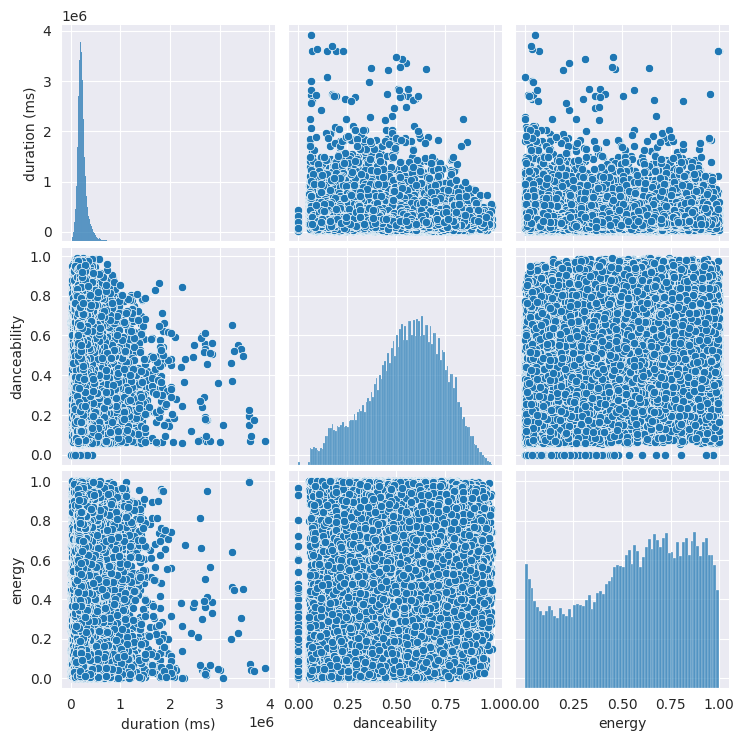

In [8]:
sns.pairplot(train_data[['duration (ms)', 'danceability', 'energy']])

<Axes: ylabel='energy'>

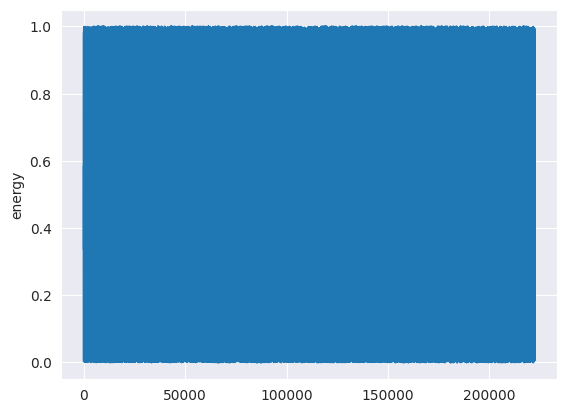

In [9]:
sns.lineplot(train_data['energy'])

In [279]:
# Remove Unnamed colums
train_data.drop('Unnamed: 0', axis=1, inplace=True)
train_data.drop('Unnamed: 0.1', axis=1, inplace=True)
train_data.drop('Unnamed: 0.2', axis=1, inplace=True)


In [280]:
import numpy as np
import pandas as pd

def replace_outliers_with_median(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df_replaced = df.copy()

    for col in numeric_cols:
        Q1 = df[col].quantile(0.05)
        Q3 = df[col].quantile(0.95)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        median = df[col].median()
        mean = df[col].mean()
        outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        df_replaced.loc[outlier_mask, col] = mean

    return df_replaced
train_data = replace_outliers_with_median(train_data)

In [281]:
def replace_outliers_zscore(df, threshold=4):
    df_replaced = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        col_zscore = zscore(df[col].astype(float), nan_policy='omit')
        outlier_mask = np.abs(col_zscore) > threshold
        median = df[col].median()
        mean = df[col].mean()
        df_replaced.loc[outlier_mask, col] = mean

    return df_replaced
train_data = replace_outliers_zscore(train_data)

In [285]:
# Create test-train splitt
X_train, X_test, y_train, y_test = train_test_split(train_data, labels, test_size=0.2, random_state=42)

# For submission
X_train = train_data
y_train = labels

In [286]:
# Train a XGBoost algorithm

# logistic_regression = LogisticRegression(verbose=1)
# logistic_regression_params = {'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'liblinear', 'sag'],}
#
# cross_validator = KFold(n_splits=5, shuffle=True, random_state=42)
#
# decision_tree = DecisionTreeClassifier(random_state=42)
# decision_tree_params = {'criterion': ['gini', 'entropy', 'log_loss'], }


normalize_xgc = ColumnTransformer(
    [('Nan Imputer' , SimpleImputer(missing_values = np.nan , strategy = 'most_frequent') , slice(0,11))]
)
standardize_xgc = ColumnTransformer([
    ('Standard Scaler', StandardScaler(), slice(0,11))
])


xgb_classifier = XGBClassifier()
xgb_params = {'booster': ['gblinear', 'gbtree', 'dart'], 'max_depth': [12, 15, 20], 'sampling_method': ['uniform', 'gradient_based'], 'tree_method': ["auto", "exact", "approx", "hist"], 'n_estimators': [15, 20, 25]}
# xgb_params = {'booster': ['gblinear', 'gbtree', 'dart'], 'max_depth': [2, 6, 12], 'sampling_method': ['uniform', 'gradient_based'], 'tree_method': ["auto", "exact", "approx", "hist"], 'n_estimators': [5, 10, 15]}
xgb_best_params = {'booster': ['gbtree'], 'max_depth': [12], 'n_estimators': [15], 'sampling_method': ['uniform'], 'tree_method': ['approx']}
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'learning_rate': [0.01, 0.05, 0.1]
}

# random_forest = RandomForestClassifier()
# random_forest_params = {'n_estimators': [10, 20, 50], 'max_depth': [2, 6, 12]}
# y_train = y_train.iloc[:, 0]


pipeline = Pipeline([
    #('normalizer', Normalizer()),
    # ('standardizer', StandardScaler()),
    # ('Nan Imputer',normalize_xgc),
    # ('StandardScaler',standardize_xgc),
    # ('classifier', GridSearchCV(logistic_regression, logistic_regression_params)),
    # ('classifier', LogisticRegressionCV(cv=cross_validator, verbose=1, max_iter=200))
    # ('classifier', GridSearchCV(estimator=decision_tree, param_grid=decision_tree_params)),
    ('classifier', XGBClassifier()),
    # ('classifier', XGBClassifier(booster='gbtree', max_depth=12, n_estimators=15, sampling_method='uniform', tree_method="approx")),
    # ('classifier', GridSearchCV(estimator=xgb_classifier, param_grid=param_grid)),
    # ('classifier', GridSearchCV(estimator=random_forest, param_grid=random_forest_params)),
])

pipeline.fit(X_train, y_train)


,steps,"[('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None


In [13]:
# If GridSearchCV, check which parameters where the best
pipeline['classifier'].best_params_

AttributeError: 'XGBClassifier' object has no attribute 'best_params_'

Matches: 42919 of 44470
Accuracy: 0.9651225545311446


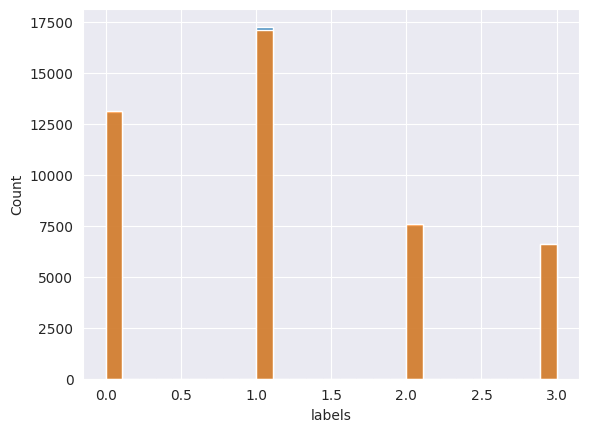

In [284]:
# # Test the performance of the model in the test/train split
y_pred = pipeline.predict(X_test)

y_pred = pd.Series(y_pred, index=y_test.index)
y_pred.name = 'labels'
y_test_s = pd.Series(y_test['labels'], index=y_test.index)

sns.histplot(y_pred)
sns.histplot(y_test_s)

matches = (y_pred == y_test_s)
print(f'Matches: {matches.sum()} of {len(y_pred)}')
print(f'Accuracy: {matches.sum() / len(y_test_s)}')

In [287]:
# Run the pipeline on the train set
challenge_data = pd.read_csv('278_labelled_uri_test_no_label.csv',  sep=';')

to_write = pd.DataFrame()
to_write['ID'] = challenge_data['Unnamed: 0']

# Remove unwanted columns
challenge_data.drop('uri', axis=1, inplace=True)
challenge_data.drop('Unnamed: 0', axis=1, inplace=True)
challenge_data.drop('Unnamed: 0.1', axis=1, inplace=True)
challenge_data.drop('Unnamed: 0.2', axis=1, inplace=True)

# Run the pipeline
results = pipeline.predict(challenge_data)
to_write['Labels'] = results


to_write.to_csv('results.csv', index=False)